In [113]:
import json

import openturns as ot
import os

import numpy as np

import pylab as plt
import pickle 

plt.rcParams['text.usetex'] = True
plt.rcParams['figure.dpi']= 500

# Import Data

In [33]:
distribution_alpha = ot.Normal(101.6612, 4.0)
distribution_alpha.setDescription([r"$\alpha$"])
#
distribution_beta = ot.Normal(0.0233, 0.0005)
distribution_beta.setDescription([r"$\beta$"])
#
distribution_epsilon_e = ot.Triangular(0.2, 0.3, 0.5)
distribution_epsilon_e.setDescription([r"$\epsilon_e$"])
#
distribution_epsilon_c = ot.Triangular(0.0, 0.05, 0.3)
distribution_epsilon_c.setDescription([r"$\epsilon_c$"])
#
dp_factor = 1.0e-6
distribution_dp = ot.Triangular(0.5 * dp_factor, 5.0 * dp_factor, 10.0 * dp_factor)
distribution_dp.setDescription([r"$d_p$"])
#
distribution_gamma_p0 = ot.Triangular(1.0e-09, 4.5e-09, 8.0e-09)
distribution_gamma_p0.setDescription([r"$\Gamma_p(0)$"])
#
distribution_av = ot.Triangular(0.1e-4, 7.8e-4, 12e-4)
distribution_av.setDescription([r"$a_v$"])
#
distributionList = [
    distribution_alpha,
    distribution_beta,
    distribution_epsilon_e,
    distribution_epsilon_c,
    distribution_dp,
    distribution_gamma_p0,
    distribution_av,
]
distribution = ot.ComposedDistribution(distributionList)

labels = [marginal.getDescription()[0] for marginal in distributionList]

In [114]:
# Parameters of the Steam Generator
input_dic = {}
input_dic['SG'] = json.load(open('../../data/SG_cleaning_conditioning.json'))

In [115]:
# Color scheme for chemical conditioning
colors_n = {'Morpholine': {'9.2': 'lightgreen', '9.6': 'forestgreen'},
             'ETA': {'9.6': 'slateblue'}}

In [117]:
# Time indices in days
t = np.load('../../data/SG_time.npy')

In [34]:
dataset_HL = ot.Sample.ImportFromCSVFile('../../data/SG_MC_HL.csv')

In [35]:
inputSample = dataset_HL[:,0:7]

In [36]:
outputSample = dataset_HL[:,7:]

# Compute PCE

In [37]:
def ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, distribution
):
    """
      Create a sparse polynomial chaos based on least squares.

      * Uses the enumerate rule in basis.
      * Uses the LeastSquaresStrategy to compute the coefficients based on
        least squares.
      * Uses LeastSquaresMetaModelSelectionFactory to use the LARS selection method.
      * Uses FixedStrategy in order to keep all the coefficients that the
        LARS method selected.

    Source : https://openturns.github.io/openturns/latest/auto_meta_modeling/polynomial_chaos_metamodel/plot_chaos_cv.html
    with a bug fix: replace getStrataCumulatedCardinal with getBasisSizeFromTotalDegree

      Parameters
      ----------
      inputTrain : Sample
          The input design of experiments.
      outputTrain : Sample
          The output design of experiments.
      multivariateBasis : Basis
          The multivariate chaos basis.
      totalDegree : int
          The total degree of the chaos polynomial.
      distribution : Distribution.
          The distribution of the input variable.

      Returns
      -------
      result : PolynomialChaosResult
          The estimated polynomial chaos.
    """
    selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
    projectionStrategy = ot.LeastSquaresStrategy(
        inputTrain, outputTrain, selectionAlgorithm
    )
    enumerateFunction = multivariateBasis.getEnumerateFunction()
    basisSize = enumerateFunction.getBasisSizeFromTotalDegree(totalDegree)  # OK
    adaptiveStrategy = ot.FixedStrategy(multivariateBasis, basisSize)
    chaosalgo = ot.FunctionalChaosAlgorithm(
        inputTrain, outputTrain, distribution, adaptiveStrategy, projectionStrategy
    )
    chaosalgo.run()
    result = chaosalgo.getResult()
    return result

In [38]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    distributionList
)

## Distribution of the predictivity coefficient for different $q$-norms

In [39]:
q_norm = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

In [66]:
def compute_sample_Q2_q_norm(inputSample, outputSample, numberAttempts, q_norm, split_fraction = 0.75):
    """
    For a given sample size N, for degree from 1 to maxDegree,
    repeat the following experiment numberAttempts times:
    create a sparse least squares chaos and compute the Q2
    using n_valid points.
    """

    sampleSize = inputSample.getSize()
    mixingDistribution = ot.KPermutationsDistribution(sampleSize, sampleSize)
    Q2sample = ot.Sample(numberAttempts, len(q_norm))
    
    #Fix the degree, take it small
    totalDegree = 2
    
    for k in range(len(q_norm)):
        q = q_norm[k]
        # use of hyperbolic enumeration rule
        enumerateFunction = ot.HyperbolicAnisotropicEnumerateFunction(inputSample.getDimension(), q)
        multivariateBasis = ot.OrthogonalProductPolynomialFactory([distribution.getMarginal(i) for i in range(distribution.getDimension())], enumerateFunction
)
        print("q-norm = {}".format(q))
        for i in range(numberAttempts):
            # Randomize the sample
            X_train = ot.Sample(inputSample)
            Y_train = ot.Sample(outputSample)
            newIndices = mixingDistribution.getRealization()
            X_train = X_train[newIndices]
            Y_train = Y_train[newIndices]
            # Split
            split_index = int(split_fraction * sampleSize)
            X_test = X_train.split(split_index)
            Y_test = Y_train.split(split_index)
            # Train
            chaosResult = ComputeSparseLeastSquaresChaos(
                X_train, Y_train, multivariateBasis, totalDegree, distribution
            )
            metamodel = chaosResult.getMetaModel()
            # Test
            val = ot.MetaModelValidation(X_test, Y_test, metamodel)
            Q2_score = val.computePredictivityFactor()
            Q2sample[i, k - 1] = Q2_score.norm1() / Q2_score.getDimension()
    return Q2sample

In [103]:
calculate = False

In [104]:
if calculate:
    numberAttempts = 5  # Number of repetitions typical time ~ 20min
    Q2sample = compute_sample_Q2_q_norm(inputSample, outputSample[:,:], numberAttempts, q_norm)
else:
    if os.path.getsize('Q2_q_norm_HL.pkl') > 0:      
        with open('Q2_q_norm_HL.pkl', "rb") as f:
            unpickler = pickle.Unpickler(f)
            Q2sample = unpickler.load()

In [43]:
#Save the realization
with open("Q2_q_norm_HL.pkl", "wb") as f:
    pickle.dump(Q2sample, f)

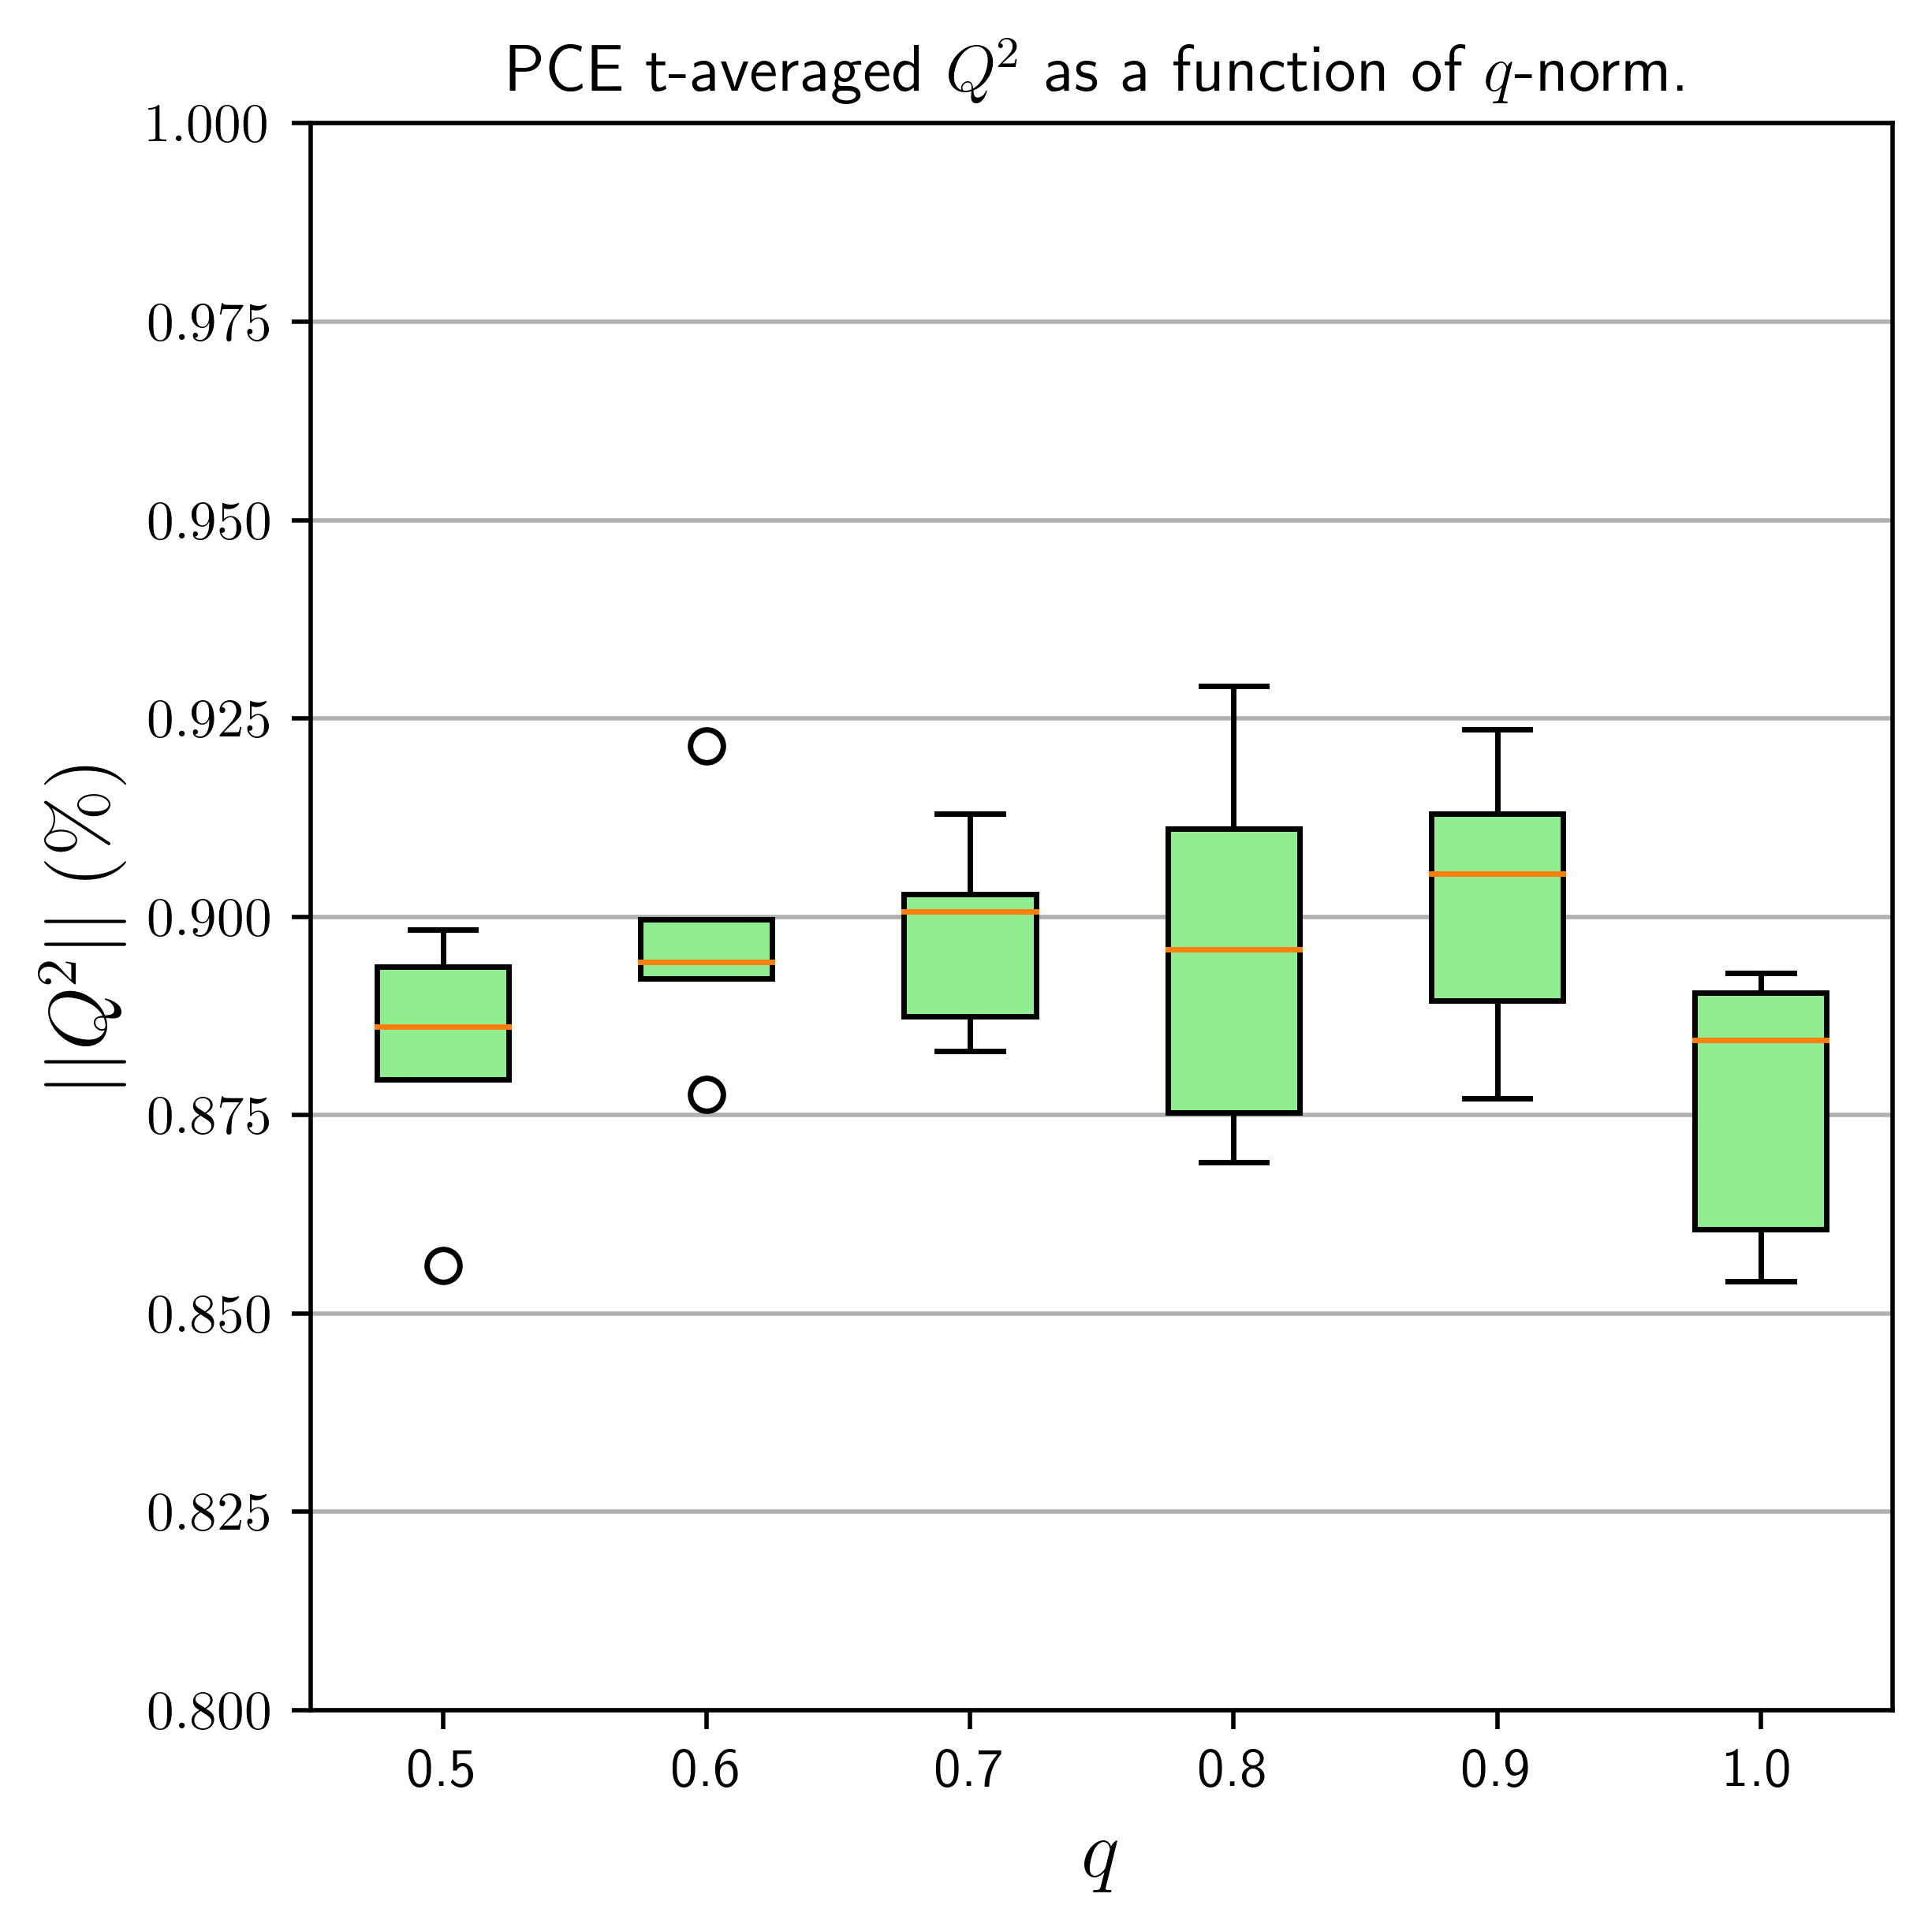

In [105]:
fig, ax = plt.subplots(1,1,figsize=(5,5), layout='tight')
bpl = ax.boxplot(np.array(Q2sample), patch_artist=True)
colors = ['lightgreen']*6
for patch, color in zip(bpl['boxes'], colors):
    patch.set_facecolor(color)
ax.set_ylim(0.8,1.0)
ax.set_xlabel(r"$q$", fontsize=15)
ax.set_ylabel(r"$|| Q^2  ||\;(\%)$", fontsize=15)
ax.set_xticks([1,2,3,4,5,6], q_norm)
ax.yaxis.grid(True)
ax.set_title(r"PCE t-averaged $Q^2$ as a function of $q$-norm.")

fig.savefig('../../plots/PCE/TPD_PCE_Q2_q_norm_sensitivity.pdf', format='pdf', bbox_inches='tight')
fig.savefig('../../plots/PCE/TPD_PCE_Q2_q_norm_sensitivity.png', format='png', bbox_inches='tight')

## Distribution of the predictivity coefficient for different degrees



In [83]:
#Degree list
degrees = [1, 2, 3, 4, 5, 6]


In [84]:
def compute_sample_Q2_degree(inputSample, outputSample, numberAttempts, degrees, split_fraction = 0.75):
    """
    For a given sample size N, for degree from 1 to maxDegree,
    repeat the following experiment numberAttempts times:
    create a sparse least squares chaos and compute the Q2
    using n_valid points.
    """

    sampleSize = inputSample.getSize()
    mixingDistribution = ot.KPermutationsDistribution(sampleSize, sampleSize)
    Q2sample = ot.Sample(numberAttempts, len(q_norm))
    
    # use of hyperbolic enumeration rule
    # We fix the q-norm according to the previous study
    q = 0.5
    enumerateFunction = ot.HyperbolicAnisotropicEnumerateFunction(inputSample.getDimension(), q)
    multivariateBasis = ot.OrthogonalProductPolynomialFactory([distribution.getMarginal(i) for i in range(distribution.getDimension())], enumerateFunction
)
    for k in range(len(degrees)):
        totalDegree = degrees[k]
        print("degree = {}".format(totalDegree))
        for i in range(numberAttempts):
            # Randomize the sample
            X_train = ot.Sample(inputSample)
            Y_train = ot.Sample(outputSample)
            newIndices = mixingDistribution.getRealization()
            X_train = X_train[newIndices]
            Y_train = Y_train[newIndices]
            # Split
            split_index = int(split_fraction * sampleSize)
            X_test = X_train.split(split_index)
            Y_test = Y_train.split(split_index)
            # Train
            chaosResult = ComputeSparseLeastSquaresChaos(
                X_train, Y_train, multivariateBasis, totalDegree, distribution
            )
            metamodel = chaosResult.getMetaModel()
            # Test
            val = ot.MetaModelValidation(X_test, Y_test, metamodel)
            Q2_score = val.computePredictivityFactor()
            Q2sample[i, k - 1] = Q2_score.norm1() / Q2_score.getDimension()
    return Q2sample

In [97]:
calculate = False

In [98]:
if calculate:
    numberAttempts = 5  # Number of repetitions typical time ~ 15min
    Q2sample = compute_sample_Q2_degree(inputSample, outputSample[:,:], numberAttempts, degrees)
else:
    if os.path.getsize('Q2_deg_HL.pkl') > 0:      
        with open('Q2_deg_HL.pkl', "rb") as f:
            unpickler = pickle.Unpickler(f)
            Q2sample = unpickler.load()

In [99]:
#Save the realization
with open("Q2_deg_HL.pkl", "wb") as f:
    pickle.dump(Q2sample, f)

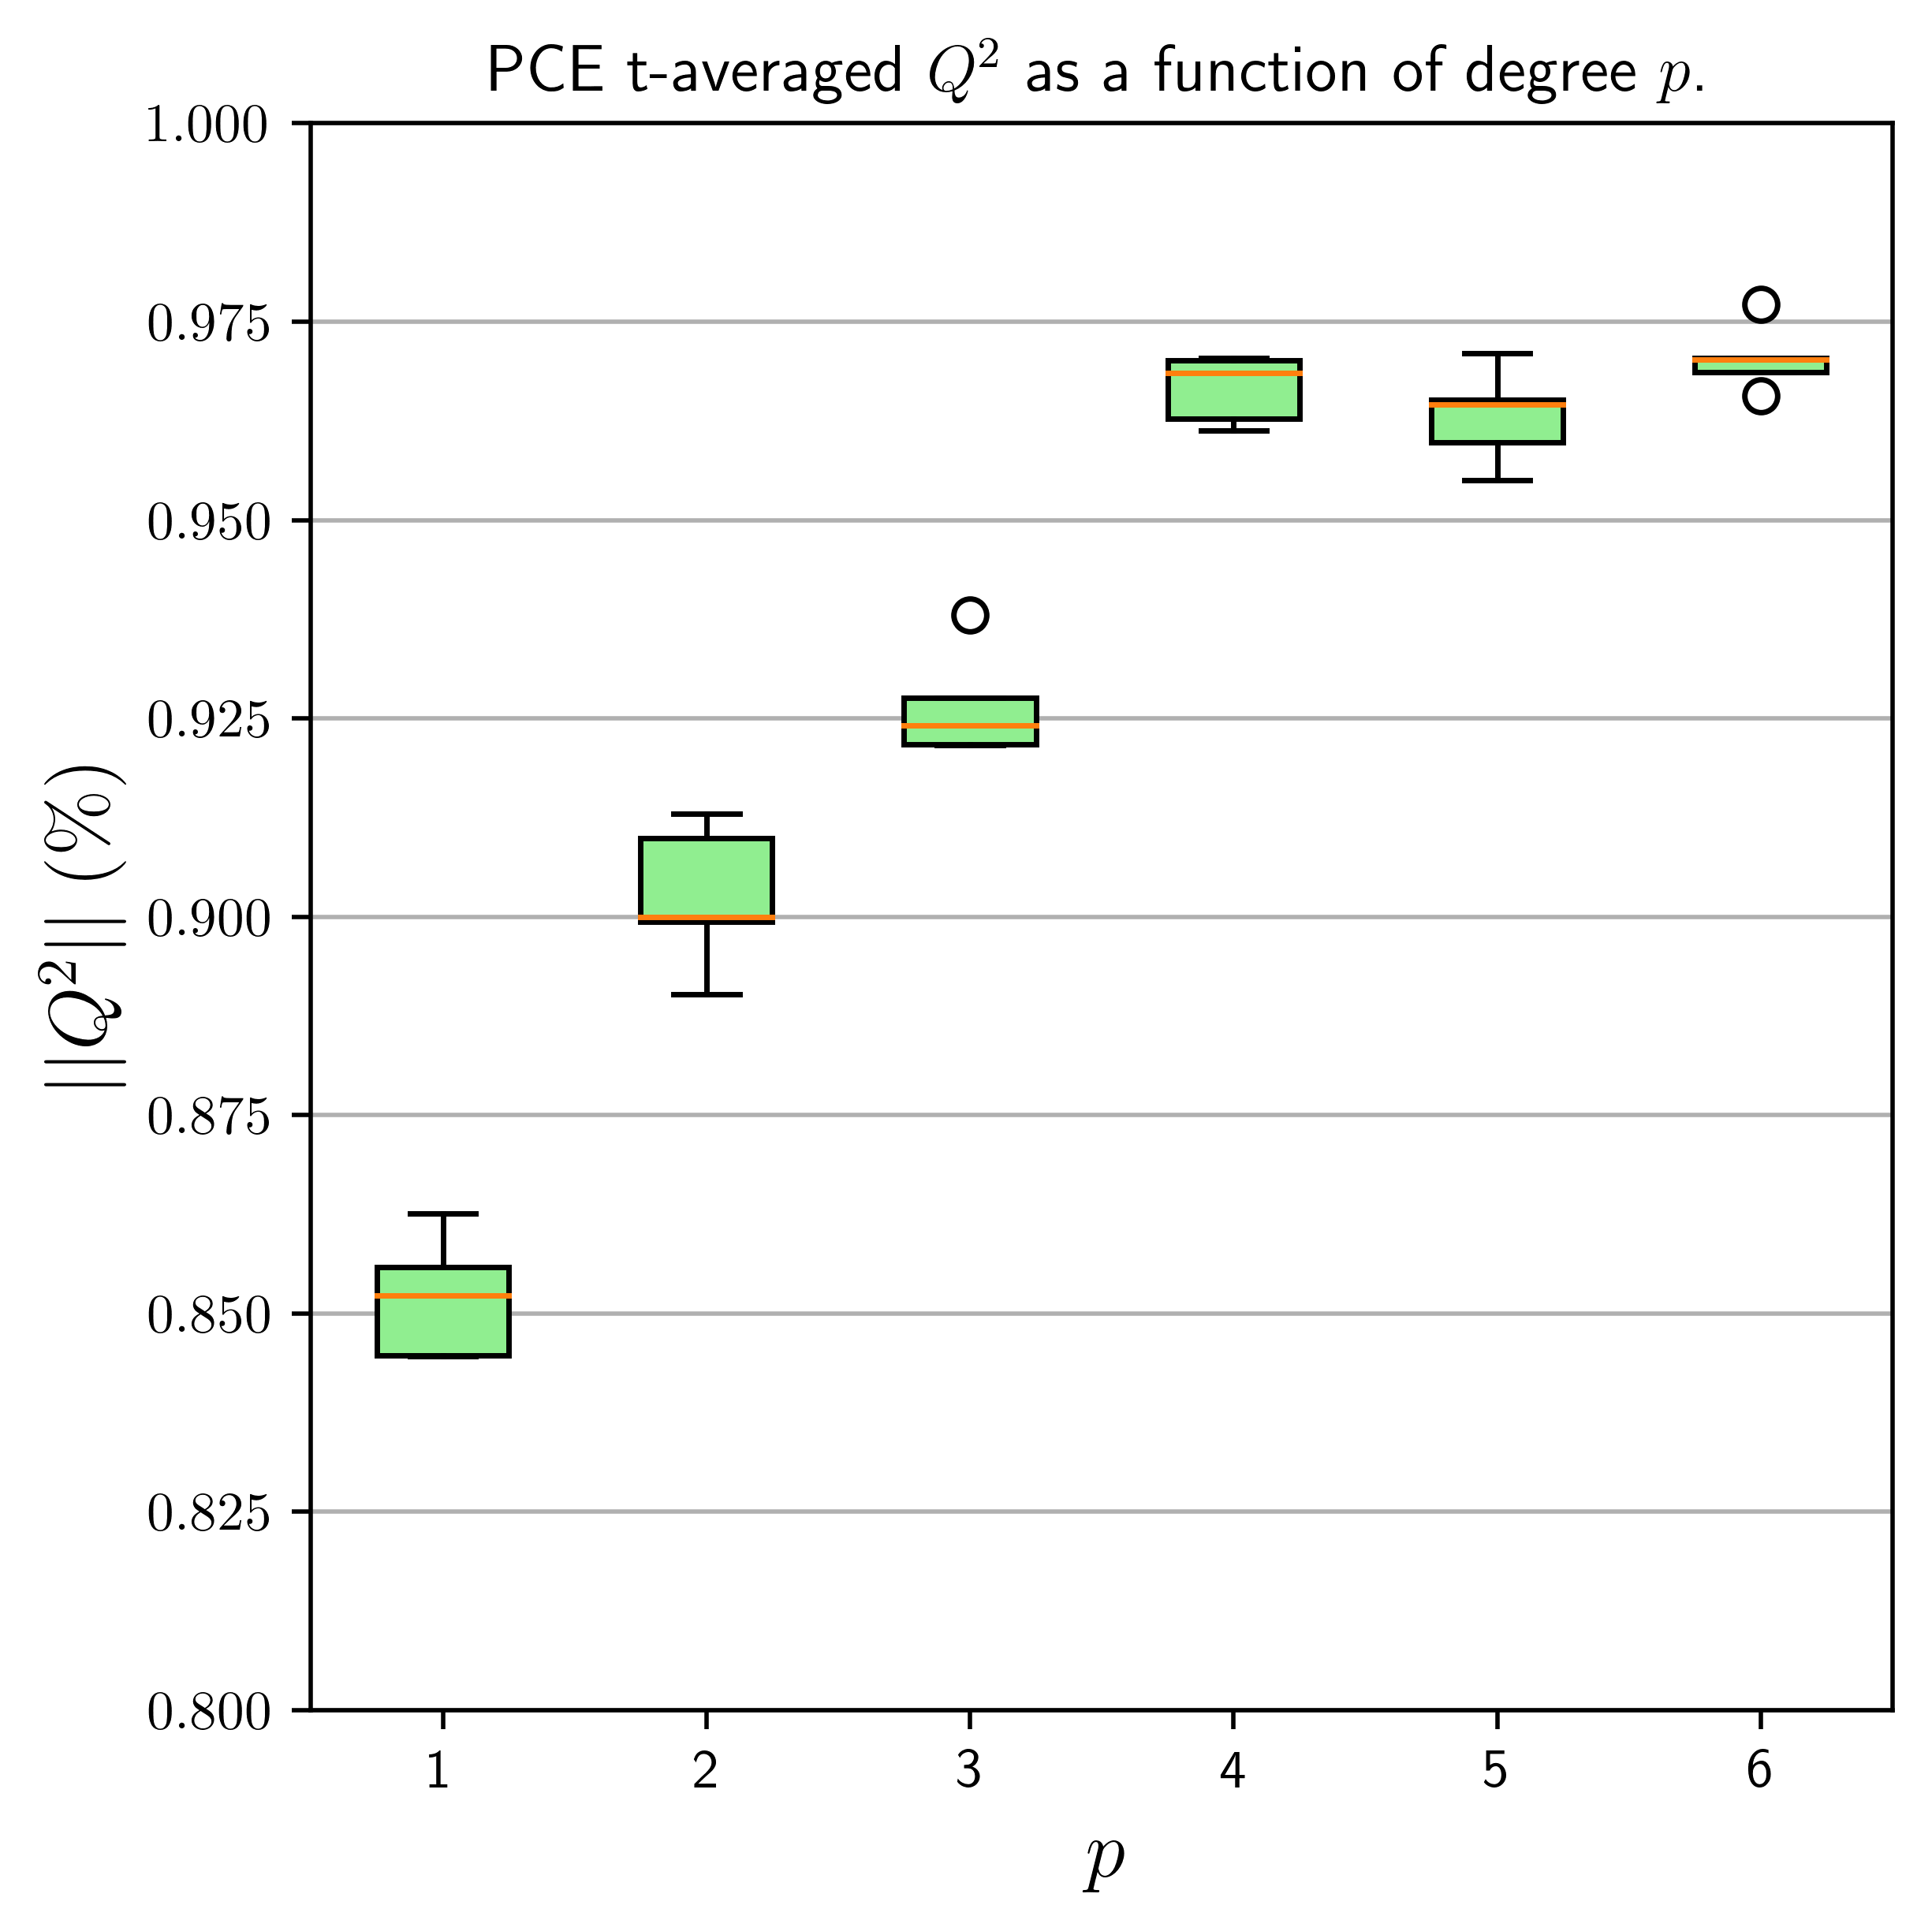

In [102]:
fig, ax = plt.subplots(1,1,figsize=(5,5), layout='tight')
bpl = ax.boxplot(np.array(Q2sample), patch_artist=True)
colors = ['lightgreen']*6
for patch, color in zip(bpl['boxes'], colors):
    patch.set_facecolor(color)
ax.set_ylim(0.8,1.0)
ax.set_xlabel(r"$p$", fontsize=15)
ax.set_ylabel(r"$|| Q^2 || \;(\%)$", fontsize=15)
ax.set_xticks([1, 2, 3, 4, 5, 6], degrees)
ax.yaxis.grid(True)
ax.set_title(r"PCE t-averaged $Q^2$ as a function of degree $p$.")

fig.savefig('../../plots/PCE/TPD_PCE_Q2_deg_sensitivity.pdf', format='pdf', bbox_inches='tight')
fig.savefig('../../plots/PCE/TPD_PCE_Q2_deg_sensitivity.png', format='png', bbox_inches='tight')

# Construction of optimal PCE

In [77]:
# Define the polynomial basis
q = 0.5
enumerateFunction = ot.HyperbolicAnisotropicEnumerateFunction(inputSample.getDimension(), q)
multivariateBasis = ot.OrthogonalProductPolynomialFactory([distribution.getMarginal(i) for i in range(distribution.getDimension())], enumerateFunction
)

split_fraction = 0.75
totalDegree = 4

training_sample_size = inputSample.getSize()

X_train = ot.Sample(inputSample)
Y_train = ot.Sample(outputSample)
split_index = int(split_fraction * training_sample_size)

X_test = X_train.split(split_index)
Y_test = Y_train.split(split_index)

chaosResult = ComputeSparseLeastSquaresChaos(
        X_train, Y_train, multivariateBasis, totalDegree, distribution
    )

In [107]:
pce = chaosResult.getMetaModel()

In [108]:
with open("PCE_metamodel.pkl", "wb") as f:
    pickle.dump(pce, f)                                                          

# Variation of $t\mapsto Q^2(t)$

In [110]:
inputTest, outputTest = inputSample[750:, :], outputSample[750:, :]
val = ot.MetaModelValidation(inputTest, outputTest, pce)
Q2 = val.computePredictivityFactor()

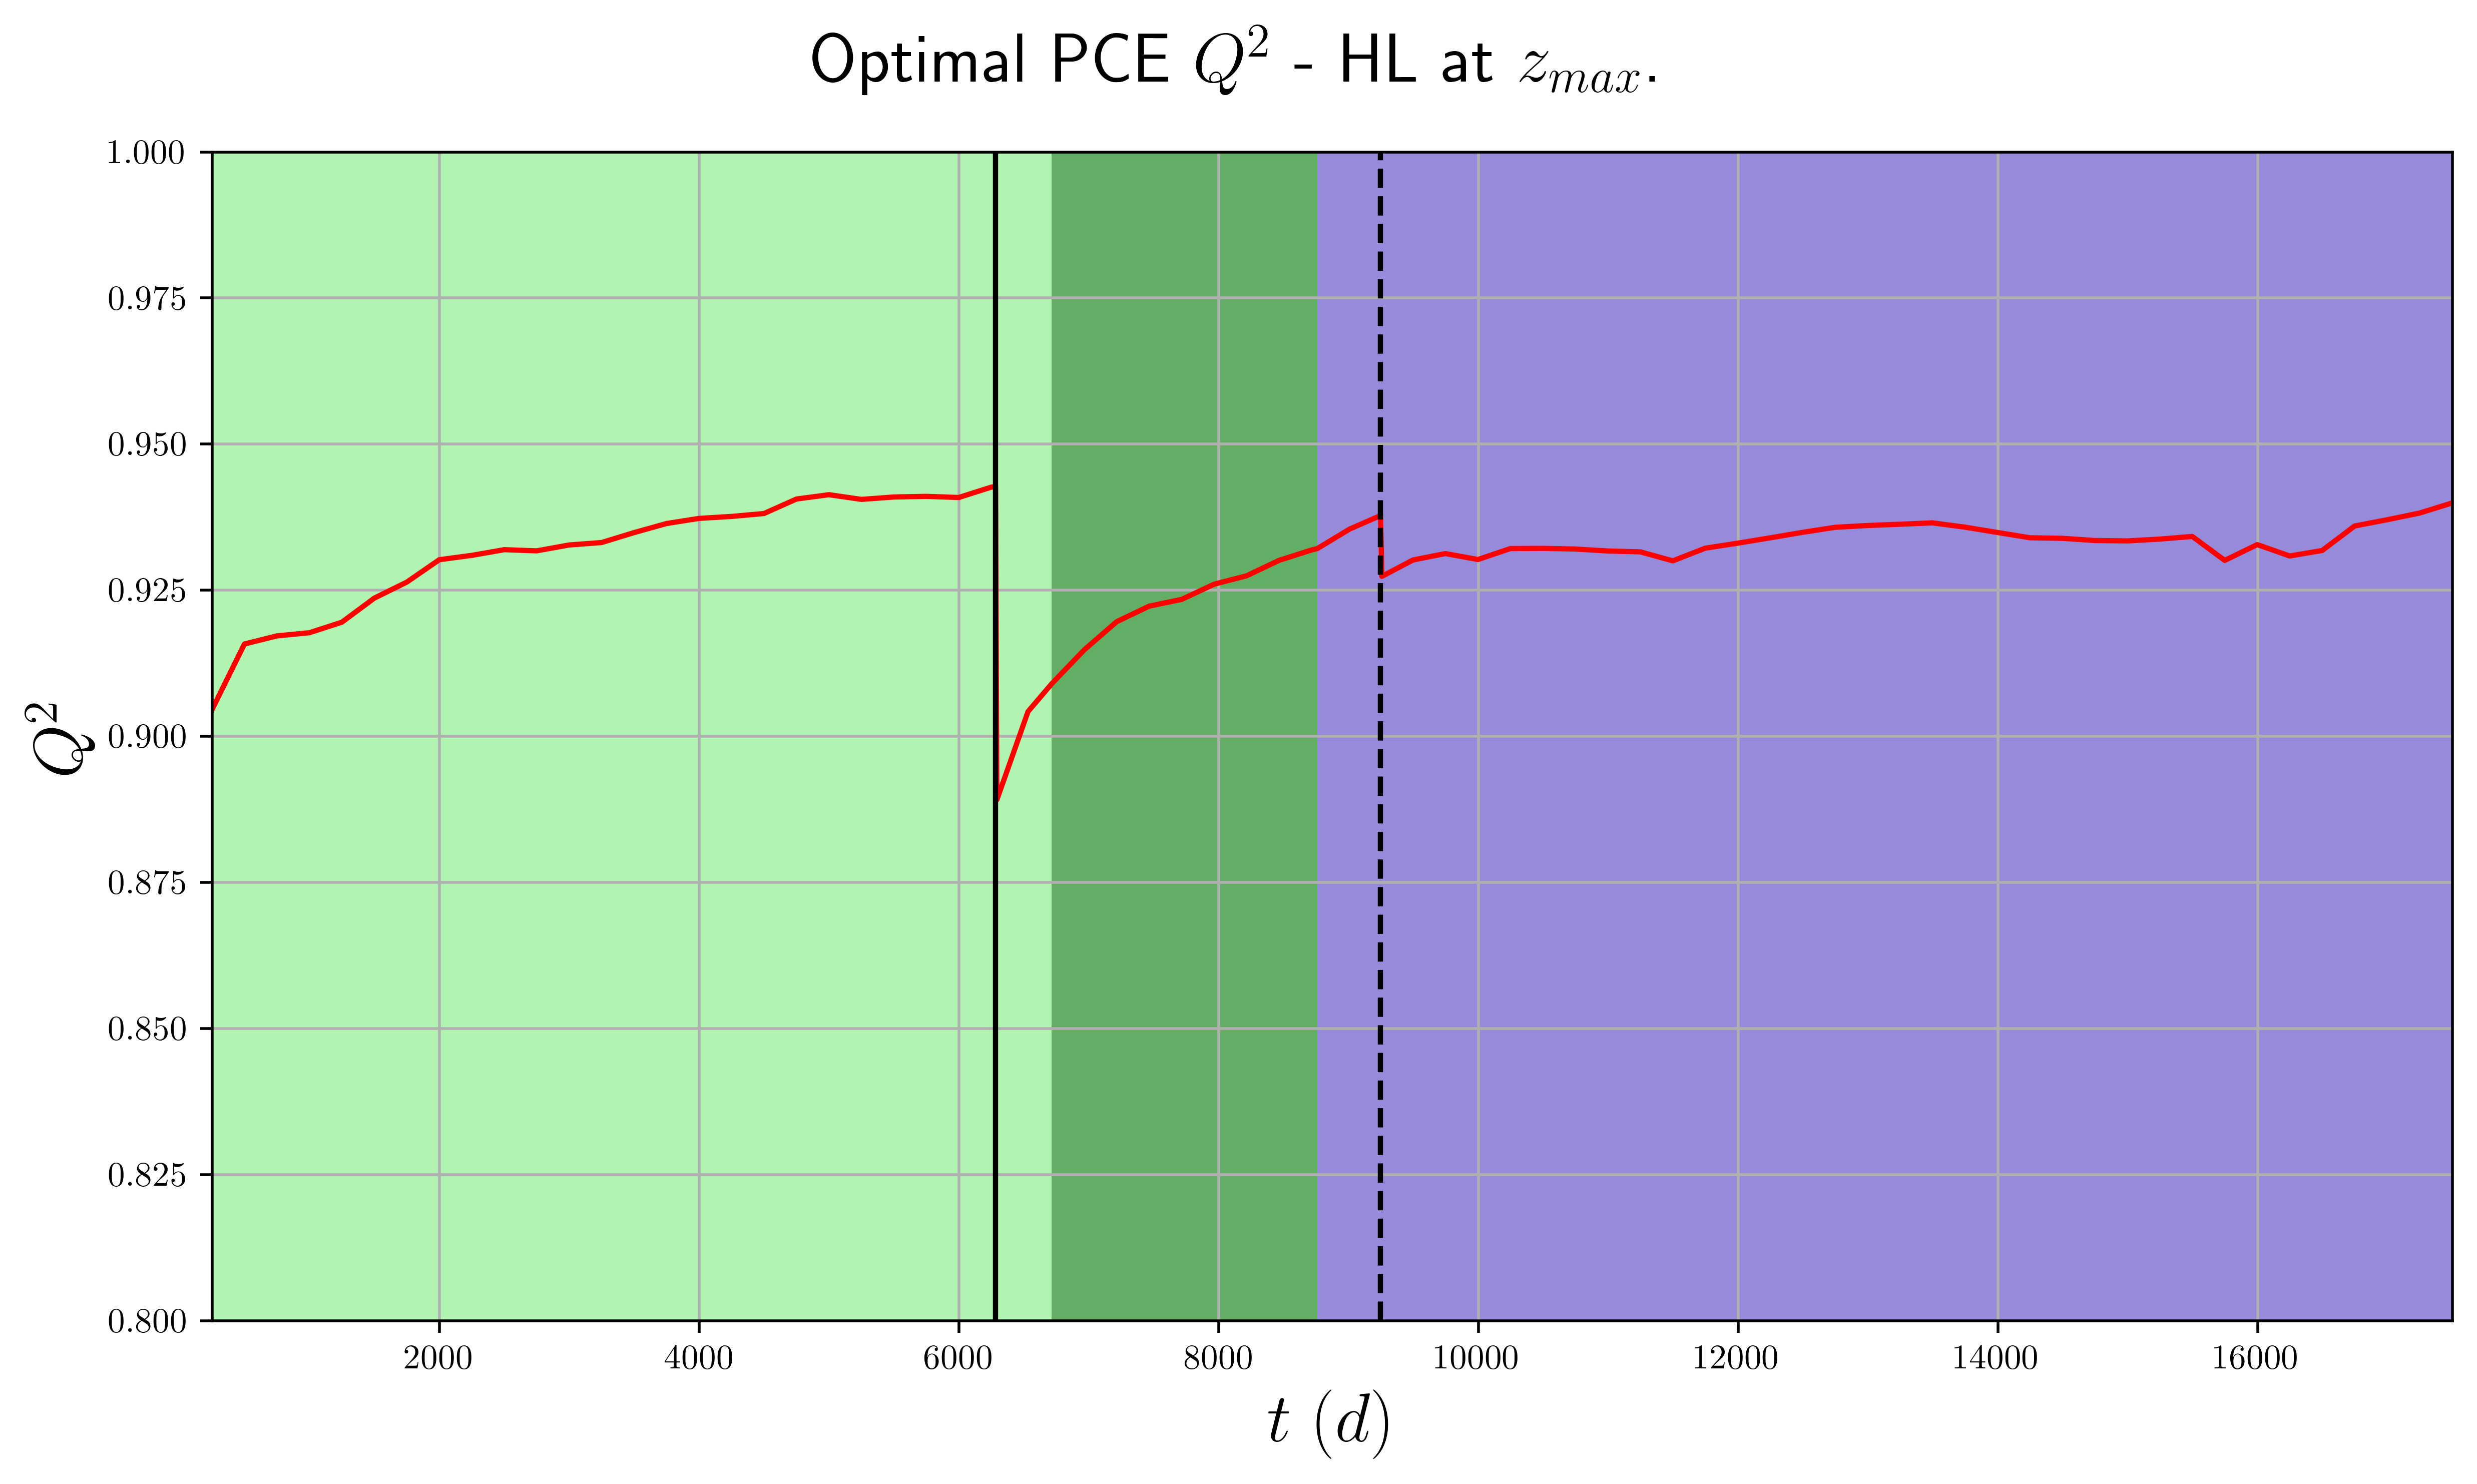

In [122]:
nrow, ncol = 1, 1
fig, axs = plt.subplots(nrow, ncol, figsize=(10,6), layout='tight')

#Chemical conditioning
cond = input_dic['SG']['chimie']['conditionnementSecondaire']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, max(t)
    else:
        t_i, t_f = cond[k]['nbHeuresExploit']/24, cond[k+1]['nbHeuresExploit']/24
    c = cond[k]
    typ = colors_n[c['type']]
    col = typ[str(c['ph'])]
    axs.axvspan(t_i, t_f, facecolor=col, alpha=0.7, label='{0}, pH= {1}'.format(c['type'], c['ph']))

#Clogging trajectories
axs.grid()
axs.plot(t, Q2, c='r')
axs.set_xlim(250,17500)
axs.set_ylim(0.8,1.0)
axs.set_xlabel(r'$t\;(d)$', fontsize=20)
axs.set_ylabel(r'$Q^{2}$', fontsize=20)

#Cleaning dates
nett = input_dic['SG']['chimie']['nettoyage']
for k in range(len(nett)):
    if nett[k]['type'] == 'curatif':
        axs.axvline(x=nett[k]['nbHeuresExploit']/24, color='k', linestyle='-', linewidth=1.5, label='Curative cleaning')

    elif nett[k]['type'] == 'preventif':
        axs.axvline(x=nett[k]['nbHeuresExploit']/24, color='k', linestyle='--', linewidth=1.5, label='Preventive cleaning')

#Legend
#lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
#lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#fig.legend(lines, labels, bbox_to_anchor=(-0.01,0.7), fontsize=15)

fig.suptitle(r'Optimal PCE $Q^{2}$  - HL at $z_{max}$.', fontsize=20)
fig.savefig('../../plots/PCE/TPD_PCE_Q2_opt.pdf', format='pdf', bbox_inches='tight')
fig.savefig('../../plots/PCE/TPD_PCE_Q2_opt.png', format='png', bbox_inches='tight')